In [1]:
import os
import gc
import pickle
from sklearnex import patch_sklearn
patch_sklearn()
import numpy as np
import pandas as pd
import torch
torch.cuda.empty_cache()
# Set allowed shared memory (if using shared memory pools)
torch.multiprocessing.set_sharing_strategy('file_system')
import random
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

from botorch.models import SingleTaskGP
from botorch.models import SaasFullyBayesianSingleTaskGP
from botorch.acquisition.analytic import ExpectedImprovement
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.optim import optimize_acqf
import warnings
from botorch.exceptions import InputDataWarning
# Suppress InputDataWarning
warnings.filterwarnings("ignore", category=InputDataWarning)
print(torch.version.cuda)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
c:\Users\pkrok\anaconda3\envs\BO\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


11.8


Using device: cuda
Number of rows in the dataset: 7737
Number of rows in the dataset: 7737
Column names in the file:
['PLD (Å)', 'LCD (Å)', 'Sacc (m2/gr)', 'Porosity', 'Density (gr/cm3)', 'Qst-CH4 (kJ/mol)', '%C', '%F', '%H', '%N', '%O', '%S', '%Si', 'NCH4 - 1 bar (mol/kg)']
Normalization successful.

raw data - 
	X: torch.Size([7737, 12])
	fidelity: 1
		y: torch.Size([7737])
		cost:  torch.Size([7737])
BO iteration:  0
Total Expected Improvement: 13.199033264935743
Percentage of Max Expected Improvement: 100.0
Iteration 0: Acquired set size = 8
BO iteration:  1
Total Expected Improvement: 0.05290054458352657
Percentage of Max Expected Improvement: 0.4007910543271451
Iteration 1: Acquired set size = 13
BO iteration:  2
Total Expected Improvement: 0.005366676827089373
Percentage of Max Expected Improvement: 0.04065962043861474
Iteration 2: Acquired set size = 18
BO iteration:  3
Total Expected Improvement: 1.4531046992004482
Percentage of Max Expected Improvement: 11.009175217860339
Ite

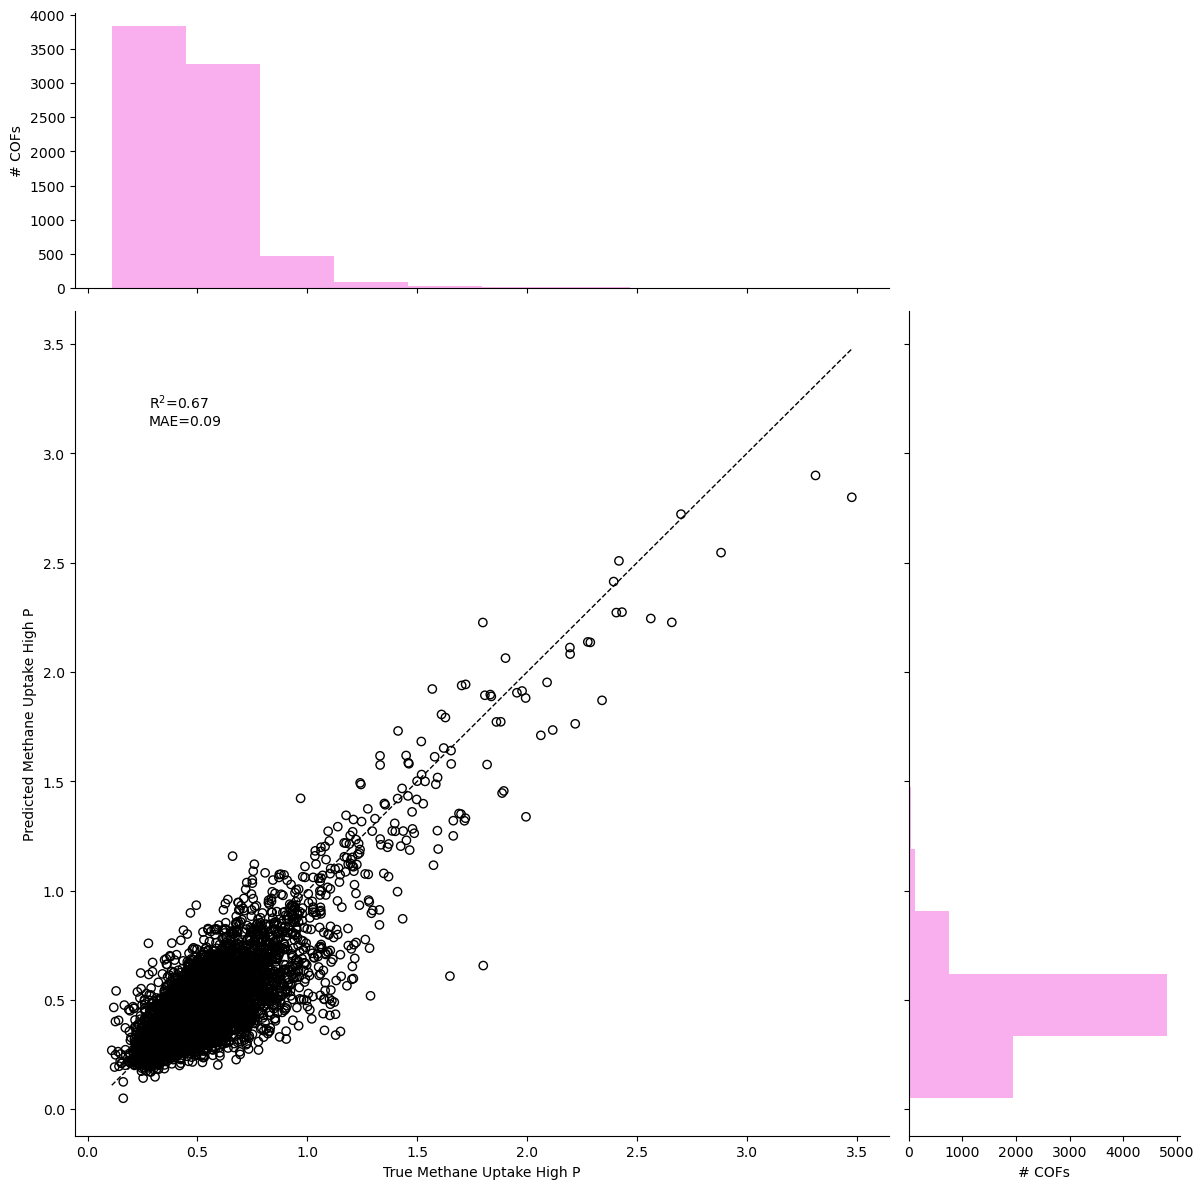

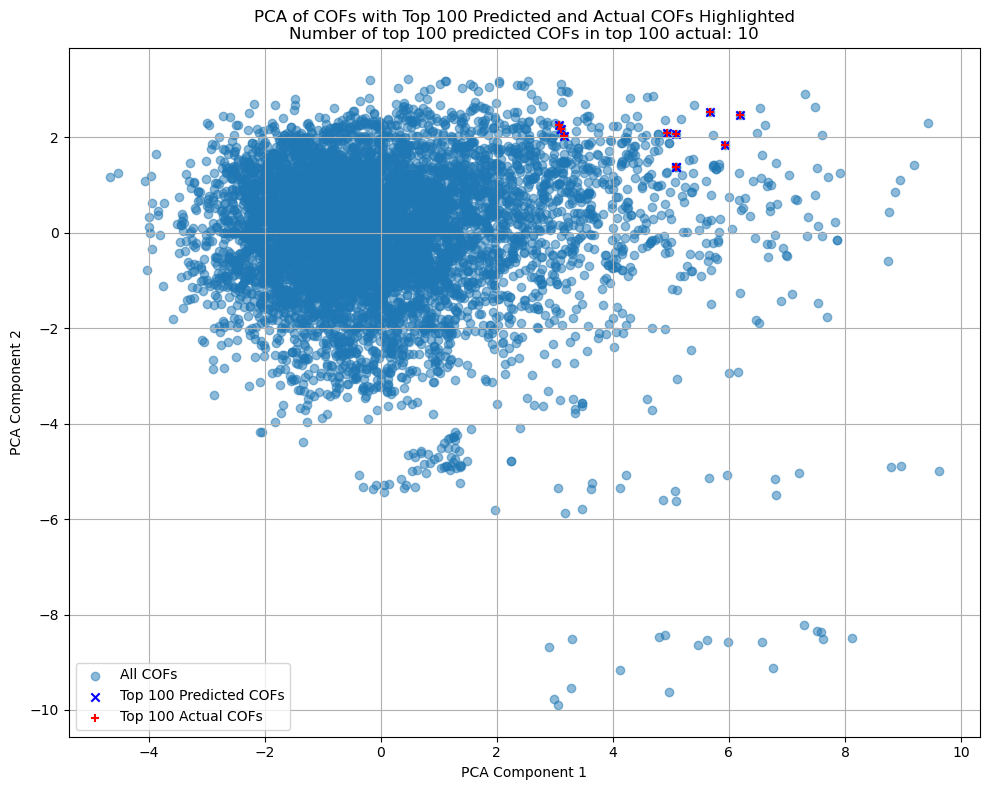

R² score: 0.6731327814240264
Explained Variance R² score: 0.7192234866763696
scikit-learn R² score: 0.6731327814240264


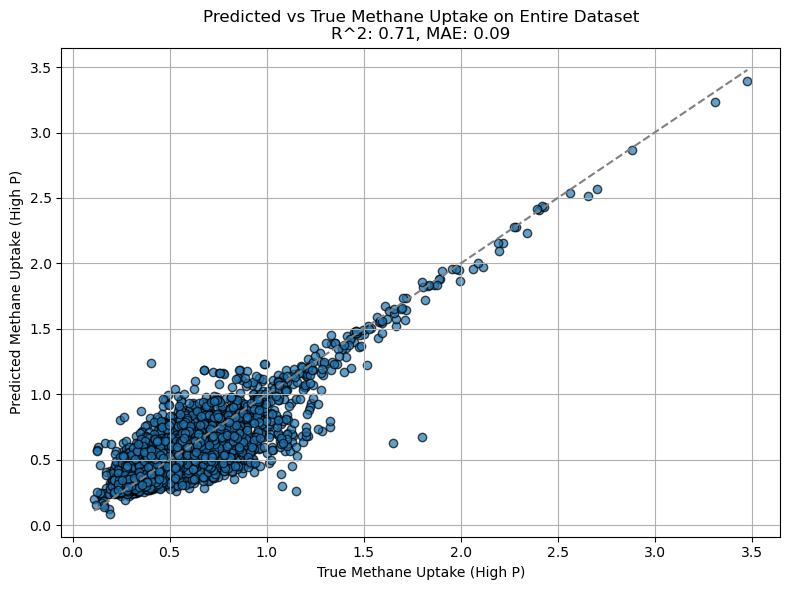

Number of actual top 100 COFs predicted by XGBoost: 10
R^2 for the predicted values of the true top 100 COFs: 0.96


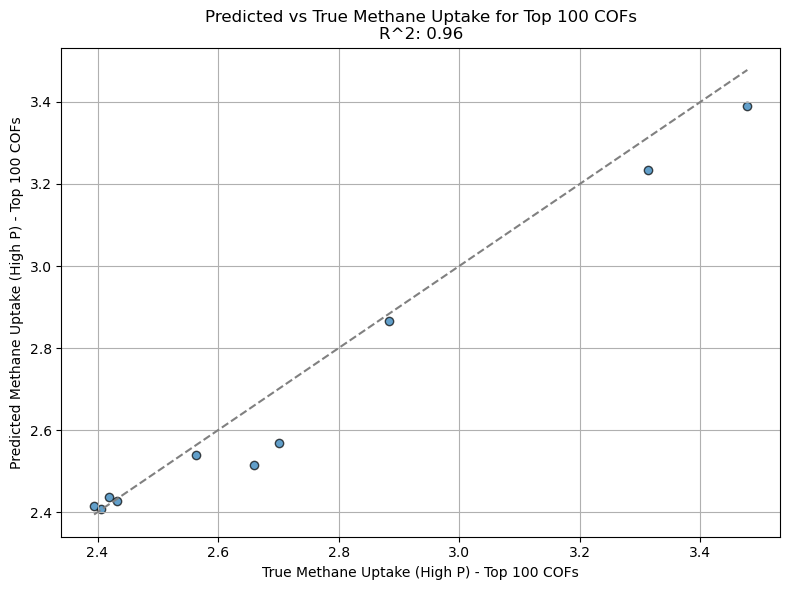

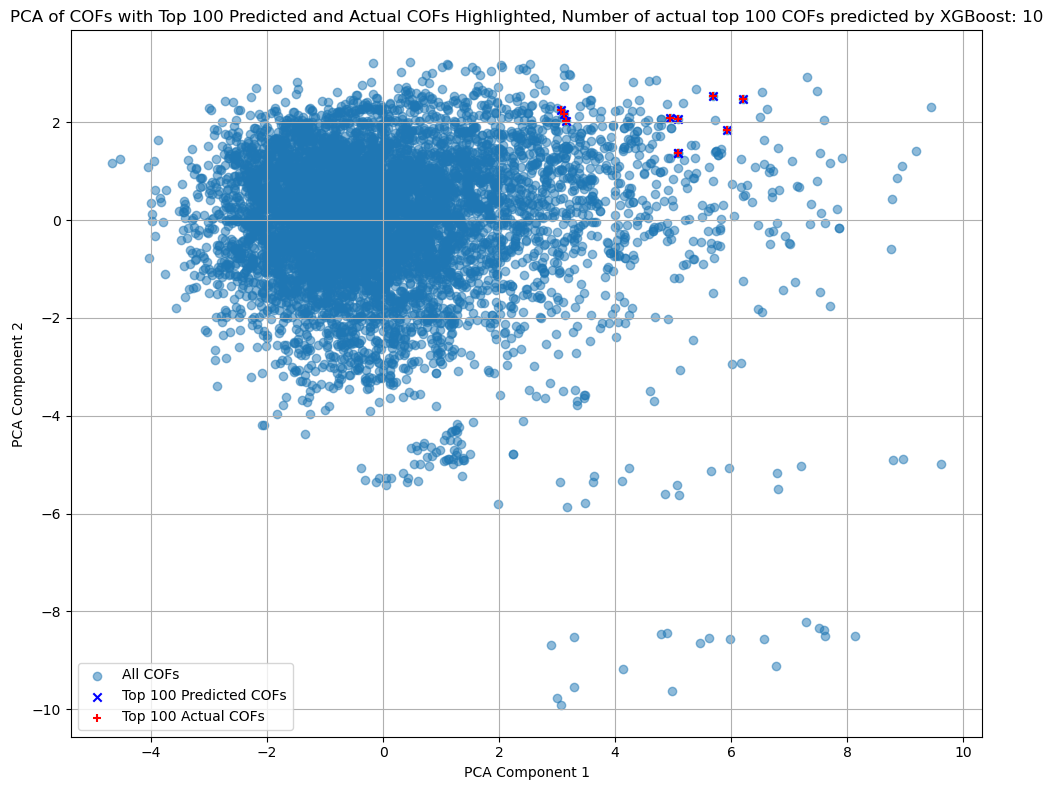

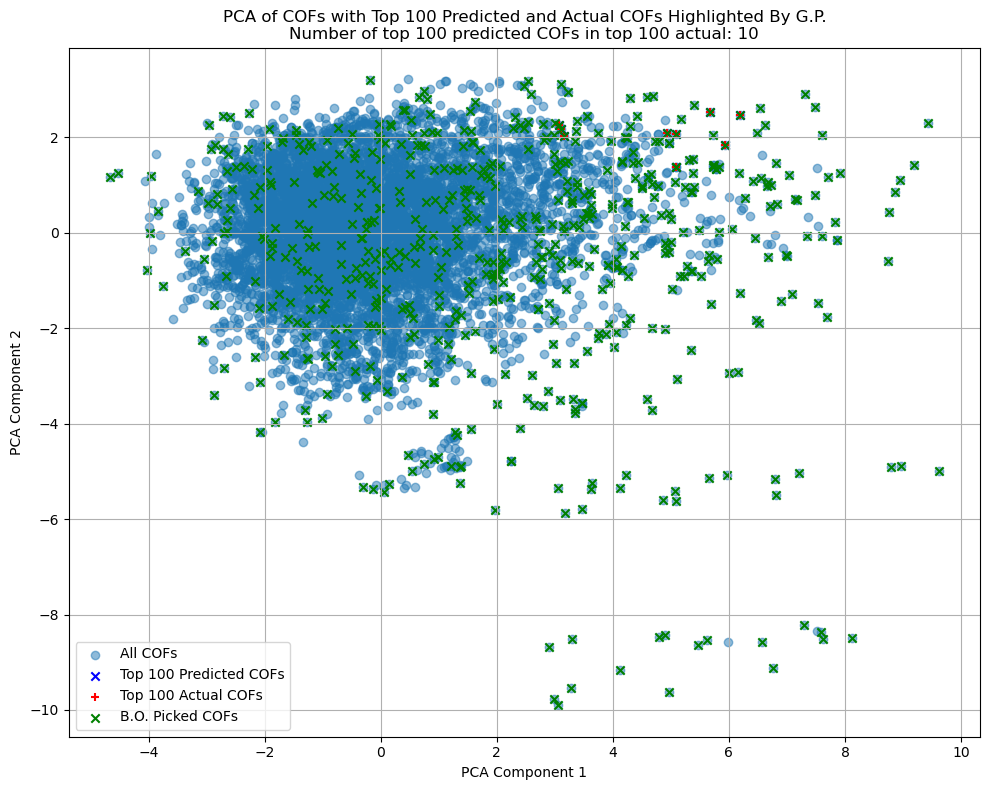

Number of B.O. picked COFs in top 100 actual COFs: 10
All BO checkpoint sets saved.


In [2]:



# MAIN PROGRAM



# --- End modified first cell ---

## Save table

In [3]:
# --- Begin modified second cell ---
import os
import pickle
import pandas as pd

# Define output directory for results (one file per checkpoint)
output_dir = 'random_sampling_plots_methane'
os.makedirs(output_dir, exist_ok=True)

# Load the original data and other settings (assuming df, feature_columns, y_column, TOP, etc. are already defined)
# Also prepare the full dataset for predictions:
X_full = df[feature_columns].values
y_full = df[y_column].values
actual_top_100_indices = np.argsort(y_full)[-TOP:]

# If you saved the BO points dictionary, load it. Otherwise, you can also scan the "bo_points" folder.
# For example, to load the pickle file:
with open("bo_points_dict.pkl", "rb") as f:
    bo_points_dict = pickle.load(f)

# Alternatively, you could build a sorted list of sample sizes from the folder "bo_points"
# sample_sizes = sorted(bo_points_dict.keys())

# Define functions to train BO-guided models (XGBoost and GP)

def run_bo_xgboost(acquired_cof_ids):
    acquired_data = df.iloc[acquired_cof_ids]
    X_train = acquired_data[feature_columns].values
    y_train = acquired_data[y_column].values
    bo_xgb_model = XGBRegressor(
        n_estimators=800,
        max_depth=5,
        eta=0.02,
        subsample=0.75,
        colsample_bytree=0.7,
        reg_lambda=0.6,
        reg_alpha=0.15,
        random_state=61
    )
    bo_xgb_model.fit(X_train, y_train)
    y_bo_xgb_pred_full = bo_xgb_model.predict(X_full)
    top_100_bo_xgb_pred_indices = np.argsort(y_bo_xgb_pred_full)[-TOP:]
    actual_top_100_in_bo = np.intersect1d(actual_top_100_indices, top_100_bo_xgb_pred_indices)
    return y_bo_xgb_pred_full, top_100_bo_xgb_pred_indices, actual_top_100_in_bo

def run_bo_gp(acquired_cof_ids):
    # Train a surrogate GP model on the BO-acquired points
    acquired_data = df.iloc[acquired_cof_ids]
    X_train = torch.tensor(acquired_data[feature_columns].values, dtype=PRECISION, device=device)
    y_train = torch.tensor(acquired_data[y_column].values, dtype=PRECISION, device=device).unsqueeze(-1)
    model = OptimizationProcessor.train_surrogate_model(X_train, y_train)
    y_bo_gp_pred_full, _ = OptimizationProcessor.mu_sigma(model, X)
    y_bo_gp_pred_full = y_bo_gp_pred_full.cpu().numpy()
    top_100_bo_gp_pred_indices = np.argsort(y_bo_gp_pred_full)[-TOP:]
    actual_top_100_in_bo = np.intersect1d(actual_top_100_indices, top_100_bo_gp_pred_indices)
    return y_bo_gp_pred_full, top_100_bo_gp_pred_indices, actual_top_100_in_bo

# Now loop over each saved BO checkpoint (sample size)
for sample_size in sorted(bo_points_dict.keys()):
    bo_sample = bo_points_dict[sample_size]  # This is a NumPy array of shape (n_points, 1)
    acquired_cof_ids = bo_sample[:, 0].astype(int).tolist()  # Convert to list of indices
    num_acquired_cofs = len(acquired_cof_ids)
    
    print(f"Processing BO checkpoint with {num_acquired_cofs} samples.")

    # DataFrame to store results; start with COF IDs and true target values for the actual top 100
    results_df = pd.DataFrame({'COF_ID': actual_top_100_indices,
                               'True_Methane_Uptake': y_full[actual_top_100_indices]})

    # --- Random runs ---
    # Loop through 20 different random states and run a random selection
    for random_state in range(20):
        random.seed(random_state)
        # Randomly select the same number of COFs as acquired by BO
        random_cof_ids = random.sample(range(len(df)), num_acquired_cofs)
        random_data = df.iloc[random_cof_ids]
        X_random_train = random_data[feature_columns].values
        y_random_train = random_data[y_column].values

        random_model = XGBRegressor(
            n_estimators=800,
            max_depth=5,
            eta=0.02,
            subsample=0.75,
            colsample_bytree=0.3,
            reg_lambda=0.6,
            reg_alpha=0.15,
            random_state=random_state
        )
        random_model.fit(X_random_train, y_random_train)
        y_random_pred_full = random_model.predict(X_full)
        top_100_random_pred_indices = np.argsort(y_random_pred_full)[-TOP:]
        actual_top_100_in_random = np.intersect1d(actual_top_100_indices, top_100_random_pred_indices)
        
        col_name = f'Random_State_{random_state}'
        # For each of the actual top 100 indices, if the random model predicted it among the top 100, record the prediction
        results_df[col_name] = pd.Series([np.nan]*len(results_df))
        if len(actual_top_100_in_random) > 0:
            for idx in actual_top_100_in_random:
                results_df.loc[results_df['COF_ID'] == idx, col_name] = y_random_pred_full[idx]
    
    # --- BO-guided XGBoost run ---
    y_bo_xgb_pred_full, top_100_bo_xgb_pred_indices, _ = run_bo_xgboost(acquired_cof_ids)
    results_df['BO_XGBoost'] = pd.Series([np.nan]*len(results_df))
    if len(top_100_bo_xgb_pred_indices) > 0:
        for idx in top_100_bo_xgb_pred_indices:
            results_df.loc[results_df['COF_ID'] == idx, 'BO_XGBoost'] = y_bo_xgb_pred_full[idx]
    
    # --- BO-guided GP run ---
    y_bo_gp_pred_full, top_100_bo_gp_pred_indices, _ = run_bo_gp(acquired_cof_ids)
    results_df['BO_GP'] = pd.Series([np.nan]*len(results_df))
    if len(top_100_bo_gp_pred_indices) > 0:
        for idx in top_100_bo_gp_pred_indices:
            results_df.loc[results_df['COF_ID'] == idx, 'BO_GP'] = y_bo_gp_pred_full[idx]

    # Optionally, compute ranking for each predictor column
    predictor_cols = [col for col in results_df.columns if col.startswith('Random_State_')]
    predictor_cols.append('BO_XGBoost')
    predictor_cols.append('BO_GP')
    for col in predictor_cols:
        results_df[col + '_Rank'] = results_df[col].rank(ascending=False, method='min')
    
    # Save the results DataFrame to an Excel file named with the current sample size
    output_file_path = os.path.join(output_dir, f'results_with_bo_predictions_{num_acquired_cofs}_samples.csv')
    results_df.to_csv(output_file_path, index=False)
    print(f"Results for sample size {num_acquired_cofs} saved to {output_file_path}")

# --- End modified second cell ---


Processing BO checkpoint with 53 samples.
Results for sample size 53 saved to random_sampling_plots_methane\results_with_bo_predictions_53_samples.csv
Processing BO checkpoint with 103 samples.
Results for sample size 103 saved to random_sampling_plots_methane\results_with_bo_predictions_103_samples.csv
Processing BO checkpoint with 153 samples.
Results for sample size 153 saved to random_sampling_plots_methane\results_with_bo_predictions_153_samples.csv
Processing BO checkpoint with 203 samples.
Results for sample size 203 saved to random_sampling_plots_methane\results_with_bo_predictions_203_samples.csv
Processing BO checkpoint with 253 samples.
Results for sample size 253 saved to random_sampling_plots_methane\results_with_bo_predictions_253_samples.csv
Processing BO checkpoint with 303 samples.
Results for sample size 303 saved to random_sampling_plots_methane\results_with_bo_predictions_303_samples.csv
Processing BO checkpoint with 353 samples.
Results for sample size 353 saved to